In [14]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
import io, glob


In [19]:
import io
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import f1_score

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize, Resize, RandomCrop, TenCrop, RandomHorizontalFlip

# a. Data Loading and Preprocessing

## Load the data set

In [21]:
# Some settings:
# --------------
train_files = 'tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'
valid_files = 'tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec'
test_files  = 'tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec'
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # hardware
n_epochs    = 10                                                            # number of training epochs
batch_size  = 20                                                           # training batch size
num_prints  = 10                                                            # number of losses to print per epoch
train_size  = 12753                                                        # number of training data samples
print_freq  = train_size // (batch_size * num_prints) + 1                  # print if iteration is a multiple of this
check_freq  = 1                                                            # save model if epoch is a multiple of this

In [22]:
# Utility functions:
# ------------------

def tfrecords_to_dataframe(fp, test = False):
    '''
    Parse data files into rows of a dataframe.
    
    arguments
    ---------
    fp : str
        Data files pattern.
        
    test : bool
        If true, data files correspond to testing data.
    '''
    def parse(pb, test = False):
        d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
        if not test:
            d['class'] = tf.io.FixedLenFeature([], tf.int64)
        return tf.io.parse_single_example(pb, d)

    df = {'id': [], 'img': []} 
    if not test:
        df['lab'] = []
    for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
        df['id'].append(sample['id'].numpy().decode('utf-8'))
        df['img'].append(sample['image'].numpy())
        if not test:
            df['lab'].append(sample['class'].numpy())
    return pd.DataFrame(df)

# ------------------------------------------------------------------------------------------------------------------------

def display_images(dataset, n, cols):
    '''
    Display a grid of labelled images of flowers.
    
    arguments
    ---------
    dataset : Dataset
        Dataset containing the flower images and labels.
        
    n : int
        Number of images to display.
        
    cols : int
        Number of columns in the grid.
    '''
    rows = n // cols if n % cols == 0 else n // cols + 1
    plt.figure(figsize = (2 * cols, 2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img, lab = dataset[i]
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(str(lab))
        plt.axis('off')
    plt.show()

In [23]:
# Classes:
# --------

class Trainset(Dataset):
    '''
    Representation of the training dataset.
    '''
    def __init__(self, frac = 1):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
        '''
        super().__init__()
        self.df = tfrecords_to_dataframe(train_files).sample(frac = frac).reset_index(drop = True)
        self.t1 = Lambda(lambda b: Image.open(io.BytesIO(b)))
        self.t2 = Compose([RandomCrop(300), 
                           RandomHorizontalFlip(), 
                           ToTensor(), 
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        transform = Compose([self.t1, Resize(np.random.randint(300, 641)), self.t2])
        sample = self.df.iloc[i]
        return transform(sample['img']), sample['lab']

# -------------------------------------------------------------------------------------------------------------------------    

class Evalset(Dataset):
    '''
    Representation of the evaluation datasets.
    '''
    def __init__(self, frac = 1, test = False):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
            
        test : bool
            If true, this dataset contains the testing data. 
            Otherwise, this dataset contains the validation data. 
        '''
        super().__init__()
        files = valid_files if not test else test_files
        self.df = tfrecords_to_dataframe(files, test).sample(frac = frac).reset_index(drop = True)
        self.transforms = [Compose([Lambda(lambda b: Image.open(io.BytesIO(b))), 
                                    Resize(scale), 
                                    TenCrop(300), 
                                    Lambda(lambda xs: torch.stack([ToTensor()(x) for x in xs])), 
                                    Lambda(lambda xs: torch.stack([Normalize([0.485, 0.456, 0.406], 
                                                                             [0.229, 0.224, 0.225])(x) for x in xs]))])
                           for scale in [372, 568]]
        self.test = test
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        sample = self.df.iloc[i]
        imgs = torch.stack([t(sample['img']) for t in self.transforms])
        return imgs, sample['lab'] if not self.test else sample['id']

# -------------------------------------------------------------------------------------------------------------------------    

class EfficientNetB0(nn.Module):
    '''
    EfficientNet B0 fine-tune.
    '''
    def __init__(self, n_classes, learnable_modules = ('classifier.1',)):
        '''
        arguments
        ---------
        n_classes : int
            Number of classification categories.
            
        learnable_modules : tuple
            Names of the modules to fine-tune.
        '''
        super().__init__()
        self.efficientnet_b0 = models.efficientnet_b0(weights = 'DEFAULT')
        self.efficientnet_b0.classifier[1] = nn.Linear(self.efficientnet_b0.classifier[1].in_features, n_classes)
        self.efficientnet_b0.requires_grad_(False)
        modules = dict(self.efficientnet_b0.named_modules())
        for name in learnable_modules:
            modules[name].requires_grad_(True)
        
    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim = 1)

In [24]:
# Training, validation, and testing data:
# ---------------------------------------
train_set    = Trainset()
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(Evalset(frac = 0.20), batch_size = 1, num_workers = 2)
test_loader  = DataLoader(Evalset(test = True), batch_size = 1, num_workers = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

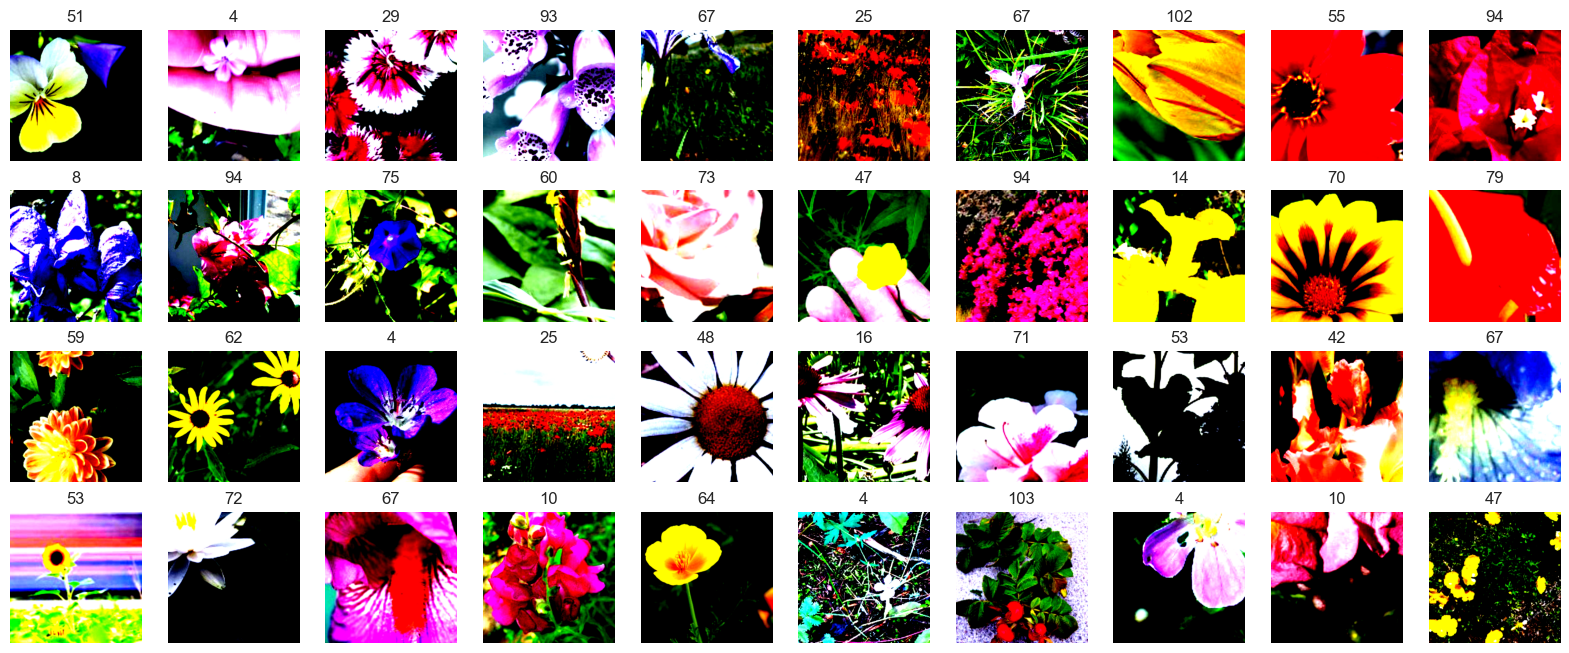

In [25]:
display_images(train_set, n = 40, cols = 10)

In [ ]:

# IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192

# GCS_PATH_SELECT = { # available image sizes
#     192: 'tpu-getting-started/tfrecords-jpeg-192x192',
#     224: 'tpu-getting-started/tfrecords-jpeg-224x224',
#     331: 'tpu-getting-started/tfrecords-jpeg-331x331',
#     512: 'tpu-getting-started/tfrecords-jpeg-512x512'
# }
# GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[1]]

# # This dataset is split three ways, training, validation, test
# tf_train_path  = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
# tf_test_path  = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
# tf_val_path  =  tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

# CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
#            'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
#            'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
#            'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
#            'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
#            'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
#            'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
#            'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
#            'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
#            'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
#            'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

# # def lrfn(epoch):
# #     if epoch < LR_RAMPUP_EPOCHS:
# #         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
# #     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
# #         lr = LR_MAX
# #     else:
# #         lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
# #     return lr
    
# # lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# # rng = [i for i in range(EPOCHS)]
# # y = [lrfn(x) for x in rng]
# # plt.plot(rng, y)
# # print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# # Utility functions:
# # ------------------

# def tfrecords_to_dataframe(fp, test = False):
#     '''
#     Parse data files into rows of a dataframe.
    
#     arguments
#     ---------
#     fp : str
#         Data files pattern.
        
#     test : bool
#         If true, data files correspond to testing data.
#     '''
#     def parse(pb, test = False):
#         d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
#         if not test:
#             d['class'] = tf.io.FixedLenFeature([], tf.int64)
#         return tf.io.parse_single_example(pb, d)

#     df = {'id': [], 'img': []} 
#     if not test:
#         df['lab'] = []
#     for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
#         df['id'].append(sample['id'].numpy().decode('utf-8'))
#         df['img'].append(sample['image'].numpy())
#         if not test:
#             df['lab'].append(sample['class'].numpy())
#     return pd.DataFrame(df)

# # ------------------------------------------------------------------------------------------------------------------------

# def display_images(dataset, n, cols):
#     '''
#     Display a grid of labelled images of flowers.
    
#     arguments
#     ---------
#     dataset : Dataset
#         Dataset containing the flower images and labels.
        
#     n : int
#         Number of images to display.
        
#     cols : int
#         Number of columns in the grid.
#     '''
#     rows = n // cols if n % cols == 0 else n // cols + 1
#     plt.figure(figsize = (2 * cols, 2 * rows))
#     for i in range(n):
#         plt.subplot(rows, cols, i + 1)
#         img, lab = dataset[i]
#         plt.imshow(img.permute(1, 2, 0).numpy())
#         plt.title(str(lab))
#         plt.axis('off')
#     plt.show()

In [ ]:
# train_df = tfrecords_to_dataframe(tf_train_path)
# print('shape of training data', train_df.shape)
# test_df = tfrecords_to_dataframe(tf_test_path, test=True)
# print('shape of test data', test_df.shape)
# val_df = tfrecords_to_dataframe(tf_val_path)
# print('shape of validation data', val_df.shape)

TypeError: expected str, bytes or os.PathLike object, not list

In [ ]:
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# EPOCHS = 40

# # Learning rate schedule
# LR_START = 0.00001
# LR_MAX = 0.0001 * strategy.num_replicas_in_sync
# LR_MIN = 0.00001
# LR_RAMPUP_EPOCHS = 0
# LR_SUSTAIN_EPOCHS = 0
# LR_EXP_DECAY = .93

In [ ]:
# # numpy and matplotlib defaults
# np.set_printoptions(threshold=15, linewidth=80)

# def batch_to_numpy_images_and_labels(data):
#     images, labels = data
#     numpy_images = images.numpy()
#     numpy_labels = labels.numpy()
#     if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
#         numpy_labels = [None for _ in enumerate(numpy_images)]
#     # If no labels, only image IDs, return None for labels (this is the case for test data)
#     return numpy_images, numpy_labels

# def title_from_label_and_target(label, correct_label):
#     if correct_label is None:
#         return CLASSES[label], True
#     correct = (label == correct_label)
#     return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
#                                 CLASSES[correct_label] if not correct else ''), correct

# def display_one_flower(image, title, subplot, red=False, titlesize=16):
#     plt.subplot(*subplot)
#     plt.axis('off')
#     plt.imshow(image)
#     if len(title) > 0:
#         plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
#     return (subplot[0], subplot[1], subplot[2]+1)
    
# def display_batch_of_images(databatch, predictions=None):
#     """This will work with:
#     display_batch_of_images(images)
#     display_batch_of_images(images, predictions)
#     display_batch_of_images((images, labels))
#     display_batch_of_images((images, labels), predictions)
#     """
#     # data
#     images, labels = batch_to_numpy_images_and_labels(databatch)
#     if labels is None:
#         labels = [None for _ in enumerate(images)]
        
#     # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
#     rows = int(math.sqrt(len(images)))
#     cols = len(images)//rows
        
#     # size and spacing
#     FIGSIZE = 13.0
#     SPACING = 0.1
#     subplot=(rows,cols,1)
#     if rows < cols:
#         plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
#     else:
#         plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
#     # display
#     for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
#         title = '' if label is None else CLASSES[label]
#         correct = True
#         if predictions is not None:
#             title, correct = title_from_label_and_target(predictions[i], label)
#         dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
#         subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
#     #layout
#     plt.tight_layout()
#     if label is None and predictions is None:
#         plt.subplots_adjust(wspace=0, hspace=0)
#     else:
#         plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
#     plt.show()

# def display_confusion_matrix(cmat, score, precision, recall):
#     plt.figure(figsize=(15,15))
#     ax = plt.gca()
#     ax.matshow(cmat, cmap='Reds')
#     ax.set_xticks(range(len(CLASSES)))
#     ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
#     ax.set_yticks(range(len(CLASSES)))
#     ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
#     plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#     titlestring = ""
#     if score is not None:
#         titlestring += 'f1 = {:.3f} '.format(score)
#     if precision is not None:
#         titlestring += '\nprecision = {:.3f} '.format(precision)
#     if recall is not None:
#         titlestring += '\nrecall = {:.3f} '.format(recall)
#     if len(titlestring) > 0:
#         ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
#     plt.show()
    
# def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
#     # zoom_pcent: X autoscales y axis for the last X% of data points
#     if subplot%10==1: # set up the subplots on the first call
#         plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
#         plt.tight_layout()
#     ax = plt.subplot(subplot)
#     ax.set_facecolor('#F8F8F8')
#     ax.plot(training)
#     ax.plot(validation)
#     ax.set_title('model '+ title)
#     ax.set_ylabel(title)
#     if zoom_pcent is not None:
#         ylen = len(training)*(100-zoom_pcent)//100
#         ymin = min([min(training[ylen:]), min(validation[ylen:])])
#         ymax = max([max(training[ylen:]), max(validation[ylen:])])
#         ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
#     if ylim is not None:
#         ymin = ylim[0]
#         ymax = ylim[1]
#         ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
#     ax.set_xlabel('epoch')
#     ax.legend(['train', 'valid.'])

In [ ]:
# def decode_image(image_data):
#     image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
#     image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
#     return image

# def read_tfrecord(example):
#     TFREC_FORMAT = {
#         "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
#         "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
#         "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
#     }
#     example = tf.io.parse_single_example(example, TFREC_FORMAT)
#     image = decode_image(example['image'])
#     label = tf.cast(example['class'], tf.int32)
#     idnum = example['id'] # image id, not used
#     return image, label # returns a dataset of (image, label) pairs

# def load_dataset(filenames, ordered=False):
#     # Read from TFRecords. For optimal performance, reading from multiple files at once and
#     # disregarding data order. Order does not matter since we will be shuffling the data anyway.

#     ignore_order = tf.data.Options()
#     if not ordered:
#         ignore_order.experimental_deterministic = False # disable order, increase speed

#     dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
#     dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
#     dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#     # returns a dataset of (image, label) pairs
#     return dataset

# def data_augment(image, label):
#     # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
#     # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
#     # of the TPU while the TPU itself is computing gradients.
#     image = tf.image.random_flip_left_right(image)
#     #image = tf.image.random_saturation(image, 0, 2)
#     return image, label   

# def get_training_dataset():
#     dataset = load_dataset(tf_train_path )
#     dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
#     dataset = dataset.repeat() # the training dataset must repeat for several epochs
#     dataset = dataset.shuffle(2048)
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
#     return dataset

# def get_validation_dataset(ordered=False):
#     dataset = load_dataset(tf_val_path , ordered=ordered)
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.cache()
#     dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
#     return dataset

# def count_data_items(filenames):
#     # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
#     n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
#     return np.sum(n)

# NUM_TRAINING_IMAGES = count_data_items(tf_train_path )
# NUM_VALIDATION_IMAGES = count_data_items(tf_val_path )
# STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
# VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
# print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))


In [ ]:
# # data dump
# print("Training data shapes:")
# for image, label in get_training_dataset().take(3):
#     print(image.numpy().shape, label.numpy().shape)
# print("Training data label examples:", label.numpy())

In [ ]:
# # Peek at training data
# training_dataset = get_training_dataset()
# training_dataset = training_dataset.unbatch().batch(20)
# train_batch = iter(training_dataset)

In [ ]:
# # run this cell again for next set of images
# display_batch_of_images(next(train_batch))

In [ ]:
# class TFRecordDataLoader:
#     def __init__(self, tfrecord_paths, batch_size=32, shuffle=True, buffer_size=1000):
#         """
#         Initialize the TFRecordDataLoader.
        
#         Args:
#         - tfrecord_paths (str or list): Path(s) to TFRecord file(s).
#         - batch_size (int): Number of samples per batch.
#         - shuffle (bool): Whether to shuffle the dataset.
#         - buffer_size (int): Size of shuffle buffer.
#         """
#         self.tfrecord_paths = tfrecord_paths
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.buffer_size = buffer_size
#         self.feature_description = self._define_feature_schema()

#     def _define_feature_schema(self):
#         """Defines the feature schema for TFRecord parsing."""
#         return {
#             "image": tf.io.FixedLenFeature([], tf.string),  # Image stored as raw bytes
#             "label": tf.io.FixedLenFeature([], tf.int64)    # Label stored as an integer
#         }

#     def _parse_tfrecord(self, example_proto):
#         """Parses a single TFRecord example."""
#         example = tf.io.parse_single_example(example_proto, self.feature_description)
        
#         # Decode image bytes (assuming images are stored as raw bytes)
#         image = tf.io.decode_raw(example['image'], tf.uint8)
#         image = tf.reshape(image, [28, 28, 1])  # Adjust shape as needed

#         label = tf.cast(example['label'], tf.int32)

#         return image, label

#     def load_dataset(self):
#         """Loads and preprocesses the dataset."""
#         dataset = tf.data.TFRecordDataset(self.tfrecord_paths)
#         dataset = dataset.map(self._parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

#         if self.shuffle:
#             dataset = dataset.shuffle(self.buffer_size)

#         dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
#         return dataset

In [ ]:
# tfrecord_loader = TFRecordDataLoader(tfrecord_paths="tpu-getting-started/tfrecords-jpeg-192x192/test/00-192x192-462.tfrec", batch_size=64)
# dataset = tfrecord_loader.load_dataset()

# # # Iterate through a batch
# for images, labels in dataset.take(1):
#     print("Image shape:", images.shape)
#     print("Labels:", labels.numpy())

### b. Model Selection and Fine-Tuning

### c. Training and Evaluation